## Binary Classification

The plan is to perform binary classification task of detecting an elephant in the images. Following models will be used for the task and accuracy will be computed on each of the following models:

1. VGG16
2. VGG19
3. Resnet50

Models are pretrained on imagenet dataset

In [1]:
#Ignore warnings
import warnings

from torch.utils.data import DataLoader, Dataset

#import data_utils
from tqdm import tqdm

warnings.filterwarnings ( "ignore" )

from torchvision import transforms, datasets
import glob
import os
import numpy as np
import ntpath
from skimage import io

import matplotlib.pyplot as plt
import json
from IPython import display

import pandas as pd
import torch.nn as nn

import torch
import torchvision
from torchvision import models

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline

In [2]:
# how many samples per batch to load
batch_size = 32

# convert data to a normalized torch.FloatTensor
data_transforms = transforms.Compose ( [
    transforms.ToPILImage(), # because the input dtype is numpy.ndarray
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize ( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )
    ] )

In [3]:
## Imagenet classes
with open('../data/imagenet_class_index.json','r') as json_file:
    json_labels = json.load(json_file)
    labels = {json_labels[str(k)][1] for k in range(len(json_labels))}
    

In [8]:
labels


{'Afghan_hound',
 'African_chameleon',
 'African_crocodile',
 'African_elephant',
 'African_grey',
 'African_hunting_dog',
 'Airedale',
 'American_Staffordshire_terrier',
 'American_alligator',
 'American_black_bear',
 'American_chameleon',
 'American_coot',
 'American_egret',
 'American_lobster',
 'Angora',
 'Appenzeller',
 'Arabian_camel',
 'Arctic_fox',
 'Australian_terrier',
 'Band_Aid',
 'Bedlington_terrier',
 'Bernese_mountain_dog',
 'Blenheim_spaniel',
 'Border_collie',
 'Border_terrier',
 'Boston_bull',
 'Bouvier_des_Flandres',
 'Brabancon_griffon',
 'Brittany_spaniel',
 'CD_player',
 'Cardigan',
 'Chesapeake_Bay_retriever',
 'Chihuahua',
 'Christmas_stocking',
 'Crock_Pot',
 'Dandie_Dinmont',
 'Doberman',
 'Dungeness_crab',
 'Dutch_oven',
 'Egyptian_cat',
 'English_foxhound',
 'English_setter',
 'English_springer',
 'EntleBucher',
 'Eskimo_dog',
 'European_fire_salamander',
 'European_gallinule',
 'French_bulldog',
 'French_horn',
 'French_loaf',
 'German_shepherd',
 'German_s

## Decode imagenet labels for predictions

In [4]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
idx2label = None
cls2label = None

In [5]:
elephant_labels = ['Indian_elephant','African_elephant','Mammoth','Rogue','tusker']

def decode_predictions(preds):
    global CLASS_INDEX
    global idx2label,cls2label 
    ## If indx is none
    if CLASS_INDEX is None:
        
        fpath = "../data/imagenet_class_index.json"
        idx2label = []
        cls2label = {}
        with open('../data/imagenet_class_index.json','r') as json_file:
            CLASS_INDEX = json.load(json_file)
            idx2label = [CLASS_INDEX[str(k)][1] for k in range(len(CLASS_INDEX))]
            cls2label = {CLASS_INDEX[str(k)][0]: CLASS_INDEX[str(k)][1] for k in range(len(CLASS_INDEX))}

    _, pred = torch.max(preds, 1)   
    results = []
    
    for i in pred:
        label = idx2label[(i)]
        if label in elephant_labels:
            return (1,label)
    return (0,label)
    
    

## Custom Dataloader
        

In [6]:
class BinaryClassifierDataset(Dataset):
    """Binary classifier dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with imagenames.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_path_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_path_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        pil2tensor = transforms.ToTensor()
        
        img_name = os.path.join(self.root_dir,self.image_path_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        if self.transform:
            image = self.transform(image)
        ## image, label
        
        return image.numpy(), torch.tensor(1)
    


In [7]:
elephant_dataset = BinaryClassifierDataset(csv_file='../data/binary-classifier/binary_classifier_imagepaths.csv',
                                    root_dir='../data/binary-classifier/', transform=data_transforms)



In [16]:
## dataloader
batch_size = 1
test_dataloader = torch.utils.data.DataLoader (elephant_dataset, batch_size=batch_size,shuffle=False, num_workers=8,pin_memory=True )
    

### Test data loader

In [12]:
print(f"No of images: {len(test_dataloader)}")
from pylab import rcParams
rcParams['figure.figsize'] = 40, 20

def imshow(image,ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    
    
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.numpy()
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)

No of images: 304


<Figure size 1440x720 with 0 Axes>

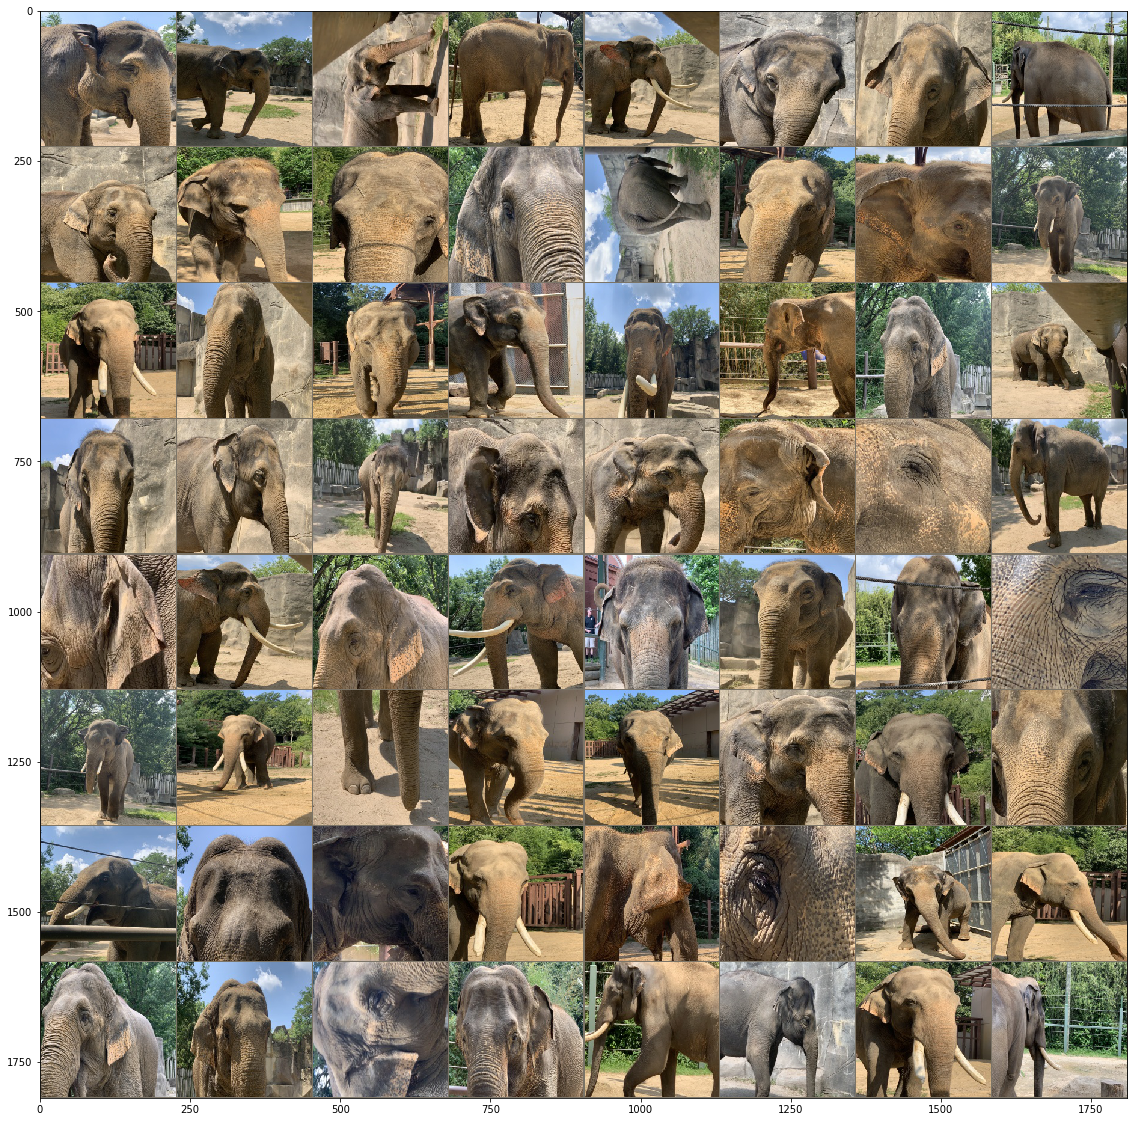

Process Process-16:
Process Process-13:
Process Process-9:
Process Process-15:
Process Process-10:
Process Process-12:
Process Process-14:
Process Process-11:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/N/u/mchivuku/.conda/envs/selfensembling/

  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
KeyboardInterrupt
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
KeyboardInterrupt
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/multiprocessing/conn

In [13]:
# get some random training images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

plt.figure(figsize=(20,10))
# show images
imshow(torchvision.utils.make_grid(images))


 ## Initialize the model

In [14]:
model_name = "resnet"
model = models.resnet50(pretrained = True) if model_name=="resnet" else models.densenet121(pretrained = True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# enable cuda labels
if (torch.cuda.is_available()):
    is_cuda = True
    model = model.to(device)
else:
    is_cuda = False

print("Initialized the model")

Initialized the model


In [15]:
if is_cuda:
    criterion  = torch.nn.CrossEntropyLoss().cuda() ## cross entropy loss
else:
    criterion  = torch.nn.CrossEntropyLoss()

In [17]:
test_loss = 0.0

## set the model to evaluation mode
model.eval()
len(test_dataloader)
total_images = 0
idx_correct = []
idx_incorrect = []
correct = 0

test_predictions = []

show_intervals = 500
for idx, (data, target) in (enumerate(test_dataloader)):
    if is_cuda:
        data, target = data.cuda(), target.cuda()
        
    ## forward pass
    output = model(data)
    
    #calculate batch loss
    loss = criterion(output,target)
    
    #update test loss
    test_loss+=loss.data.item()
    
    ## decode predictions
    pred, predicted_label = decode_predictions(output.data.cpu())
    correct += pred
    total_images+=data.size(0)
    
    ## Predictions
    test_predictions.append((pred,predicted_label))
    
    if pred==0:
        idx_incorrect.append((idx,predicted_label))
    else:
        idx_correct.append((idx,predicted_label))
        
    if total_images % show_intervals==0:
        print(f" Accuracy score: {(correct/total_images)*100}")
# average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))



 Accuracy score: 99.2
 Accuracy score: 99.6
 Accuracy score: 99.53333333333333
 Accuracy score: 99.4
 Accuracy score: 99.32
 Accuracy score: 99.33333333333333
 Accuracy score: 99.31428571428572
 Accuracy score: 99.35000000000001
 Accuracy score: 99.35555555555555
 Accuracy score: 99.33999999999999
 Accuracy score: 99.4
 Accuracy score: 99.41666666666666
 Accuracy score: 99.38461538461539
 Accuracy score: 99.38571428571429
 Accuracy score: 99.38666666666667
 Accuracy score: 99.4
 Accuracy score: 99.41176470588235
 Accuracy score: 99.41111111111111
 Accuracy score: 99.42105263157895
 Accuracy score: 99.45
 Accuracy score: 99.43809523809523
 Accuracy score: 99.44545454545455
 Accuracy score: 99.43478260869566
 Accuracy score: 99.425
 Accuracy score: 99.41600000000001
 Accuracy score: 99.41538461538461
 Accuracy score: 99.42222222222222
 Accuracy score: 99.43571428571428
 Accuracy score: 99.43448275862069
 Accuracy score: 99.43333333333332
 Accuracy score: 99.43225806451613
 Accuracy score

In [18]:
print(f" Total correct: {correct}")
print(f" Accuracy score: {(correct/len(test_dataloader))*100}")
print(f" Total {len(test_predictions)}")

 Total correct: 19320
 Accuracy score: 99.42363112391931
 Total 19432


In [20]:
total_images

19432

In [21]:
df = pd.read_csv("../data/binary-classifier/binary_classifier_imagepaths.csv")

In [33]:
str(df.iloc[1]['path'])

'Pheobe_IMG_5460.JPG'

In [61]:
correct_indx = [i for (i, l) in idx_correct]
correct_labels = [l for (i, l) in idx_correct]
correct_imagepaths = df.loc[correct_indx,:]


In [62]:
print(f" Length of correct images: {len(correct_indx)}")

 Length of correct images: 19320


In [63]:
incorrect_indx = [i for (i, l) in idx_incorrect]
incorrect_labels = [l for (i, l) in idx_incorrect]
incorrect_imagepaths = df.loc[incorrect_indx,:]
print(f" Length of incorrect images: {len(incorrect_indx)}")


 Length of incorrect images: 112


### Display correct and incorrect images

In [103]:
import imageio
import cv2
from PIL import Image
def display_grid_images(imagepaths, labels):
    w=10
    h=10
    fig=plt.figure(figsize=(24, 18))
    columns = 10
    rows = 30
    for i in range(1, columns*rows-1):
        
        fig.add_subplot(rows, columns, i)
        imgpath = os.path.join("../data/binary-classifier/",imagepaths[i][0])
           
        img = Image.open(imgpath)
        plt.imshow(img)
        plt.axis("off")
        plt.grid("off")
        if labels[i] not in elephant_labels:
             color = 'red'
        else:
             color = 'blue'
                
        plt.title(labels[i],color=color)
    plt.show()
    

## Display All Images:


In [104]:
## all images
all_paths = []
all_labels = []
for idx, row in df.iterrows():
    if idx in correct_indx:
        all_paths.append(str(row['path']))
        index = correct_indx.index(idx)
        all_labels.append(correct_labels[index])
    else:
        all_paths.append(str(row['path']))
        index = incorrect_indx.index(idx)
        all_labels.append(incorrect_labels[index])
    
        

## Correct

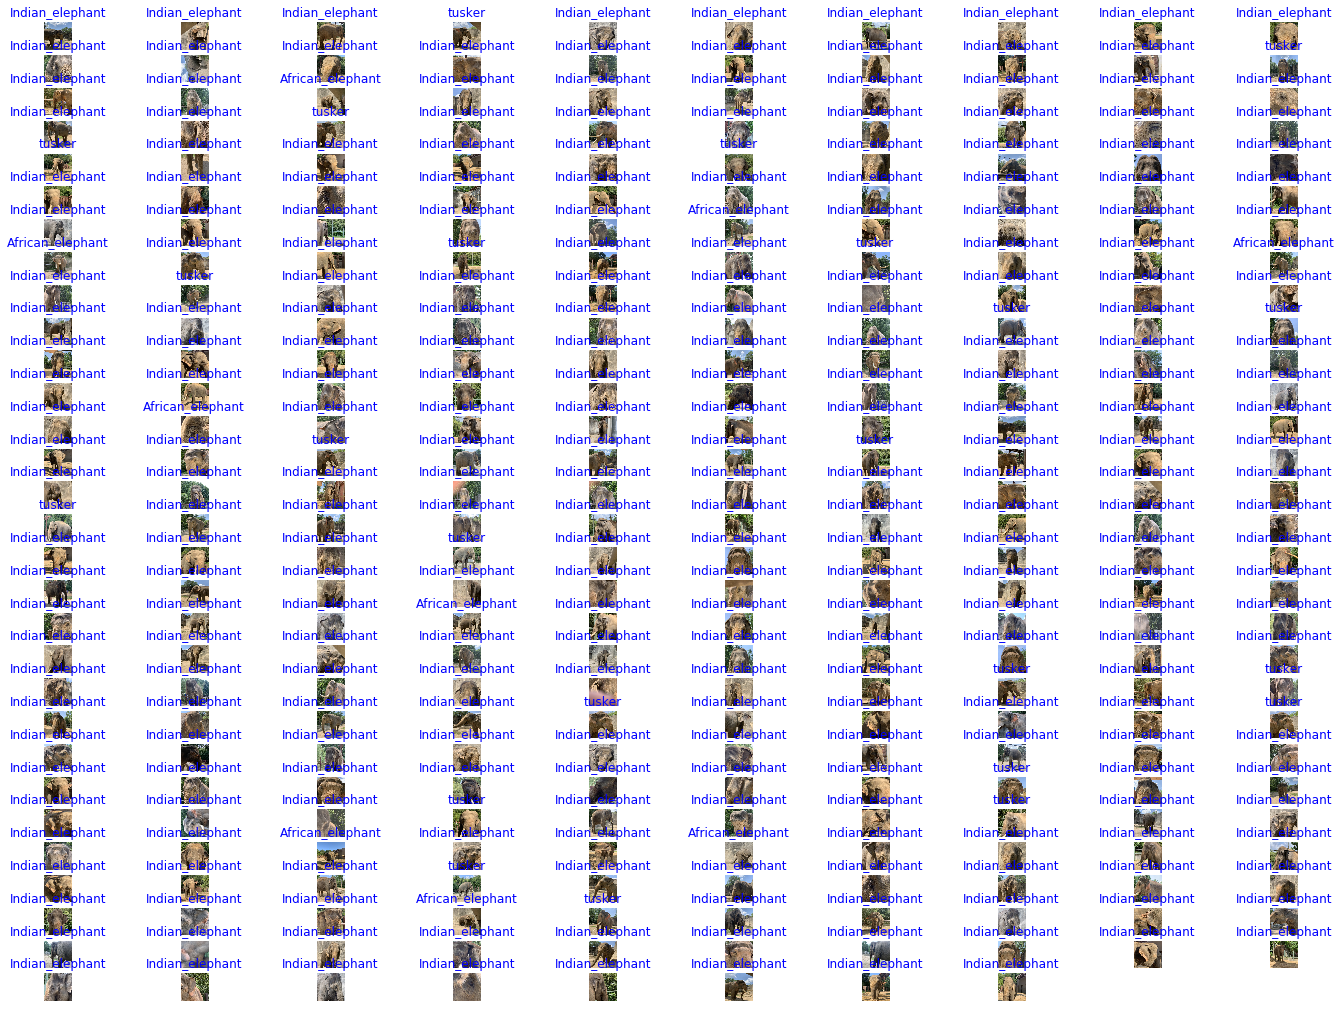

In [105]:
display_grid_images(correct_imagepaths.values.astype(str),correct_labels)

In [92]:
from collections import Counter
Counter(correct_labels)


Counter({'Indian_elephant': 17192, 'tusker': 1462, 'African_elephant': 666})

## Incorrect

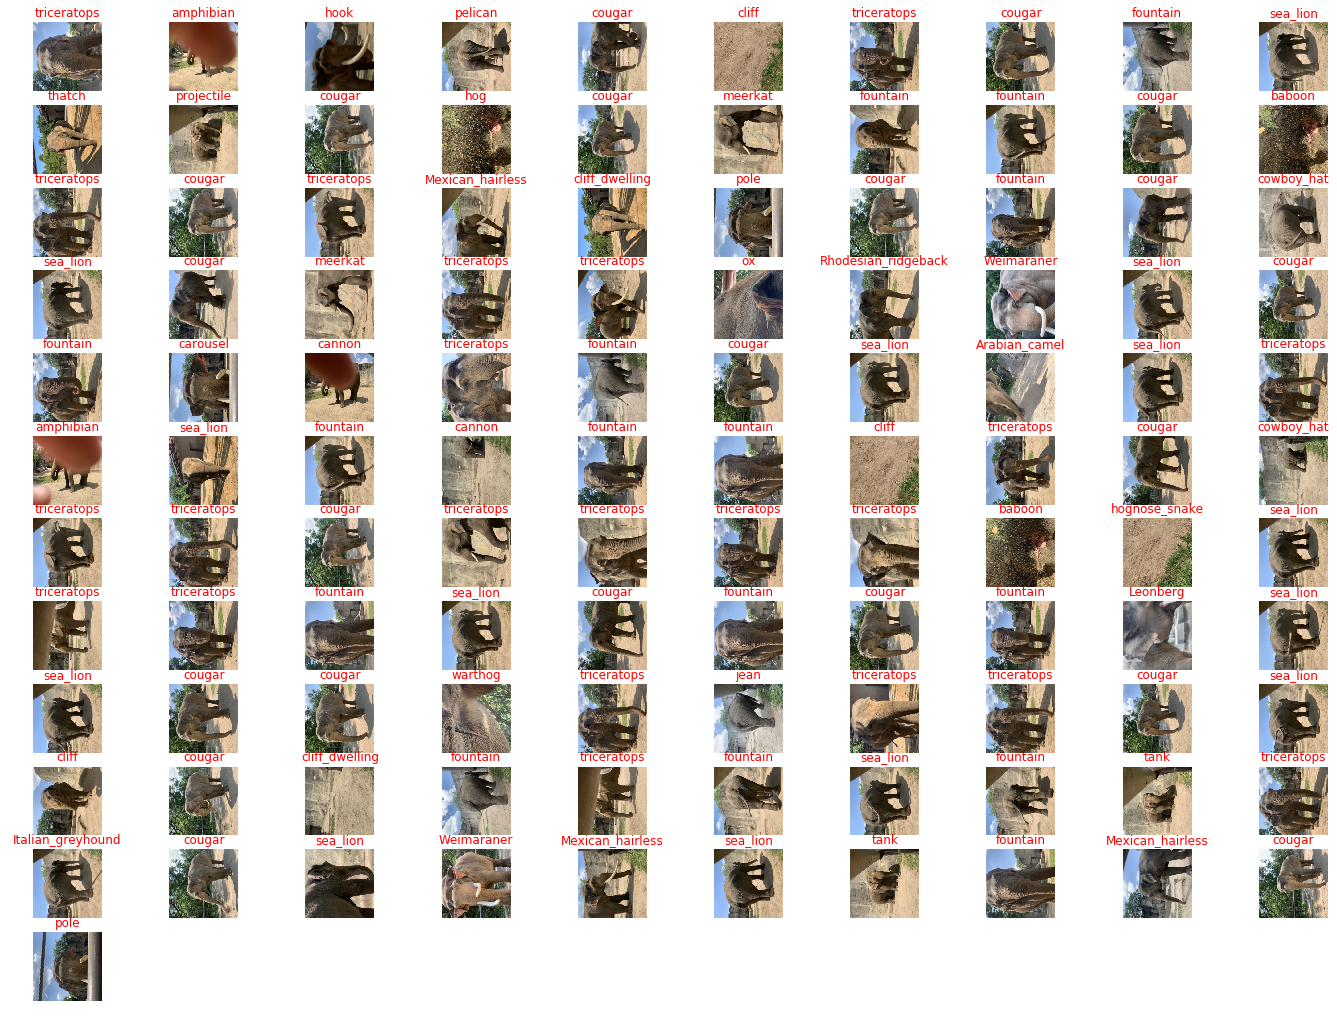

In [98]:
display_grid_images(incorrect_imagepaths.values.astype(str),incorrect_labels)

In [153]:
from collections import Counter
Counter(incorrect_labels)
keys = Counter(incorrect_labels).keys()
values = Counter(incorrect_labels).values()

In [154]:
keys

dict_keys(['Mexican_hairless', 'triceratops', 'amphibian', 'hook', 'pelican', 'cougar', 'cliff', 'fountain', 'sea_lion', 'thatch', 'projectile', 'hog', 'meerkat', 'baboon', 'cliff_dwelling', 'pole', 'cowboy_hat', 'ox', 'Rhodesian_ridgeback', 'Weimaraner', 'carousel', 'cannon', 'Arabian_camel', 'hognose_snake', 'Leonberg', 'warthog', 'jean', 'tank', 'Italian_greyhound'])

In [155]:
values

dict_values([4, 22, 2, 1, 1, 21, 3, 16, 14, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1])

In [156]:
incorrect_df = pd.DataFrame({"labels":list(keys),"count":list(values)})

In [164]:
incorrect_df.sort_values(by='count', ascending=False)

labels  count
1           triceratops     22
5                cougar     21
7              fountain     16
8              sea_lion     14
0      Mexican_hairless      4
6                 cliff      3
13               baboon      2
27                 tank      2
21               cannon      2
19           Weimaraner      2
16           cowboy_hat      2
15                 pole      2
14       cliff_dwelling      2
12              meerkat      2
2             amphibian      2
11                  hog      1
10           projectile      1
9                thatch      1
17                   ox      1
18  Rhodesian_ridgeback      1
4               pelican      1
20             carousel      1
3                  hook      1
22        Arabian_camel      1
23        hognose_snake      1
24             Leonberg      1
25              warthog      1
26                 jean      1
28    Italian_greyhound      1